## Reading Images


In [10]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm

In [11]:
def showimg(path, from_array=True, label="", figsize=(3, 3), cmap='gray'):
    """
    Display an image using matplotlib.
    
    Parameters:
    - path: str or numpy array. Path to the image file or the image array to display.
    - from_array: bool. If True, `path` is considered as a numpy array. If False, it's treated as a file path.
    - label: str. Optional title for the image.
    - figsize: tuple. Size of the figure to display.
    - cmap: str. Color map to apply if the image is grayscale.
    
    Returns:
    - None
    """
    if from_array:
        if isinstance(path, np.ndarray):
            plt.figure(figsize=figsize)
            path = cv2.cvtColor(path,cv2.COLOR_BGR2RGB)
            plt.imshow(path, cmap=cmap)
            if label:
                plt.title(label)
            plt.axis('off')
            plt.show()
        else:
            raise ValueError("Expected a numpy array for `path` when `from_array` is True.")
    else:
        if os.path.exists(path):
            image = mpimg.imread(path)
            plt.figure(figsize=figsize)
            plt.imshow(image)
            if label:
                plt.title(label)
            plt.axis('off')
            plt.show()
        else:
            raise FileNotFoundError(f"The file '{path}' does not exist.")

## Trying The Process

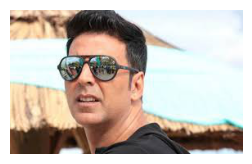

In [3]:
showimg('train/akshay_kumar/36f3127fbe.jpg',from_array=False)

Eyes Present


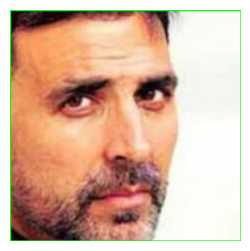

In [4]:
# Load the pre-trained Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
# Load the pre-trained Haar cascade classifier for eye detection
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye_tree_eyeglasses.xml')

# Read the input image and convert it to grayscale
image = cv2.imread('train/akshay_kumar/0d5e3950ba.jpg', cv2.IMREAD_COLOR)  # Load image in color
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Perform face detection
# detectMultiScale returns a list of rectangles where it detects faces
faces = face_cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=1, minSize=(30, 30))

# Draw rectangles around the detected faces
image_cpy = image
for (x, y, w, h) in faces:
    # Define the region of interest (ROI) in the grayscale image for each face
    roi = image[y:y+h, x:x+w]
    roi_gray = image_gray[y:y+h, x:x+w]

    # Display the region of interest (face area)
#     showimg(roi)

    # Perform eye detection within the face's ROI
    eyes = eye_cascade.detectMultiScale(roi_gray)

    # Draw rectangles around the detected eyes
    
    if len(eyes)>=2:
        # Show the face area with detected eyes
        print("Eyes Present")
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Draw rectangle around each detected face    
        
        showimg(roi)
#         return this roi
    image = image_cpy    

But Not Croping face Properly also including Bg so we use MTCNN- Multi-Task Cascaded Convolutional Neural Network For Face Detection

In [9]:

from mtcnn import MTCNN


def detect_faces_mtcnn(image):
    detector = MTCNN()
    faces = detector.detect_faces(image)
    rectangles = [face['box'] for face in faces if face['confidence'] > 0.70]
    images = []
    for rectangle in rectangles:
        x, y, w, h = rectangle
        images.append(image[y:y+h, x:x+w])
    return rectangles, images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


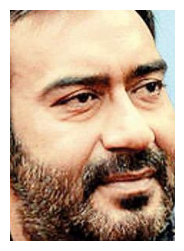

In [8]:
def detect_faces_and_eyes(image_path):
    eye_cascade = cv2.CascadeClassifier('./haarcascade_eye_tree_eyeglasses.xml')

    # Read the input image in color
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print("Error: Image not found or unable to load.")
        return None

    # Convert the image to grayscale for detection purposes
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    faces,_ = detect_faces_mtcnn(image)
    # Loop through detected faces
    for (x, y, w, h) in faces:
        # Define the region of interest (ROI) in the color image for each face
        roi_color = image[y:y+h, x:x+w]
        roi_gray = image_gray[y:y+h, x:x+w]  # Grayscale ROI for eye detection

        # Perform eye detection within the face's ROI
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # If exactly two eyes are detected
        if len(eyes) >= 2:
            return roi_color
            
        
    # If no face with exactly two eyes is detected, return None
    return None

x= detect_faces_and_eyes('./train/Faces/ajay_devgn_5.jpg')

showimg(x) if x is not None else None

## Faces Only 

In [ ]:
def process_images(source_directory, destination_directory):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    
    # Loop through each subdirectory in the source directory
    for subdir in os.listdir(source_directory):
        subdir_path = os.path.join(source_directory, subdir)

        if os.path.isdir(subdir_path):
            count = 1
            # Loop through each file in the subdirectory
            for file in tqdm(os.listdir(subdir_path),desc=f"Processing {subdir}"):
                if file.endswith('.jpg') or file.endswith('.png'):
                    file_path = os.path.join(subdir_path, file)

                    # Process the image to find faces with two eyes
                    face_image = detect_faces_and_eyes(file_path)

                    if face_image is not None:
                        # Save the detected face region
                        destination_path = os.path.join(destination_directory, f"{subdir}_{count}.jpg")
                        cv2.imwrite(destination_path, face_image)
#                         print(f"Saved face with two eyes to {destination_path}")
                        count += 1

    print("Processing and saving faces completed.")

# Example usage:
source_directory = "./train/"
destination_directory = "./preprocessed/Faces"
process_images(source_directory, destination_directory)

## Resizing Images

In [ ]:
import cv2
source = './preprocessed/faces'
resized_dest = './preprocessed/resized'

if not os.path.exists(resized_dest):
    os.makedirs(resized_dest)
    
target_size = (224,224)   
resized = []
for filename in tqdm(os.listdir(source), desc=f"Resizing. to {target_size}"):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Read the image
        img = cv2.imread(os.path.join(source, filename))
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        
        # Save the resized image to the output directory
        resized.append(resized_img)
#         cv2.imwrite(os.path.join(resized_dest, filename), resized_img)

print("Resizing complete.")
resized = np.array(resized)
np.save("resized.npy",resized)


In [ ]:
imgs= np.load('resized.npy')

In [ ]:
showimg(imgs[0])

### Wavelet Transformation


In [ ]:
import numpy as np
import pywt
import cv2    

# From Stackoverflow
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


# Example 
input_img = cv2.imread('./preprocessed/Faces/ajay_devgn_1.jpg')
im_wt = w2d(input_img,'db1',6)
showimg(im_wt)


### Now I am Trying To Vertically Stack the Original Image And Wavelett transformed Image. and Store all in array.


In [ ]:
combined_images = []
for training_image in tqdm(os.listdir('./preprocessed/Faces/')):
    # Read and resize the original color image
    original_img = cv2.imread(f"./preprocessed/Faces/{training_image}")
    resized_original_img = cv2.resize(original_img, (224, 112))
    
    # Perform wavelet transformation and resize the resulting grayscale image
    wavelet_img = w2d(original_img, 'db1', 6)
    
    resized_wavelet_img = cv2.resize(wavelet_img, (224, 112))
    
    # Convert grayscale wavelet transformed image to color (BGR)
    wavelet_img_color = cv2.cvtColor(resized_wavelet_img, cv2.COLOR_GRAY2BGR)
    
    # Concatenate color and grayscale images vertically
    combined_img = np.concatenate((resized_original_img, wavelet_img_color), axis=0)
    
    combined_images.append(combined_img)

# combined_images now contains the vertically concatenated images
X=combined_images

In [ ]:
showimg(X[0])

In [ ]:
combined_images = []
for training_image in tqdm(os.listdir('./preprocessed/Faces/')):
    # Read and resize the original color image
    original_img = cv2.imread(f"./preprocessed/Faces/{training_image}")
    resized_original_img = cv2.resize(original_img, (224, 112))
    
    # Perform wavelet transformation and resize the resulting grayscale image
    wavelet_img = w2d(original_img, 'db1', 6)
    
    resized_wavelet_img = cv2.resize(wavelet_img, (224, 112))
    
    # Convert grayscale wavelet transformed image to color (BGR)
    wavelet_img_color = cv2.cvtColor(resized_wavelet_img, cv2.COLOR_GRAY2BGR)
    
    # Concatenate color and grayscale images vertically
    combined_img = np.concatenate((resized_original_img, wavelet_img_color), axis=0)
#     combined_img = resized_original_img
    
    combined_images.append(combined_img)

# combined_images now contains the vertically concatenated images
X=combined_images

In [ ]:
showimg(X[0])

In [ ]:
X[0].shape

In [ ]:
ProcessedImages= np.array(X)
np.save('CombinedProcessedImages.npy',ProcessedImages)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model with pre-trained weights on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract embeddings (features) from an image
def extract_embeddings(x):
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x,verbose=False)
    return features.flatten()

# embedding = extract_embeddings(X[0])
# print(f"Embedding shape: {embedding.shape}, Embeddings {embedding}")


In [ ]:
X=imgs

In [ ]:
Features = []
for image in tqdm(X,desc='Extracting Features'):
    Features.append(extract_embeddings(image))

In [ ]:
NpFeatures = np.array(Features)
np.save('Vgg16Features.npy',NpFeatures)

In [5]:
import numpy as np
import os
import shutil

In [6]:
NpFeatures = np.load('Vgg16Features.npy')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(NpFeatures)

# Number of clusters
num_clusters = 5

# Apply K-means clustering on extracted features
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(NpFeatures)

In [ ]:
mapping = {}
for i,file in enumerate(os.listdir('./preprocessed/Faces/')):
    mapping[f"./preprocessed/Faces/{file}"] = cluster_labels[i]

In [ ]:
mapping

In [ ]:
for image_path, cluster_label in mapping.items():
    cluster_folder = f'ClustersKmeans/Cluster_{cluster_label}/'
    os.makedirs(cluster_folder, exist_ok=True)
    
    filename = os.path.basename(image_path)
    destination_path = os.path.join(cluster_folder, filename)
    
    try:
        shutil.copyfile(image_path, destination_path)
        print(f"Copied '{filename}' to '{cluster_folder}'")
    except FileNotFoundError:
        print(f"Error: '{filename}' not found in '{images_folder}'")
    except FileExistsError:
        print(f"Error: '{filename}' already exists in '{cluster_folder}'")

In [ ]:
import os
import cv2
import numpy as np
import face_recognition
from imutils import paths
from multiprocessing import Pool

def process_image(image_path, detection_method='cnn'):
    # Load the input image and convert it from BGR to RGB
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    boxes = face_recognition.face_locations(rgb_image, model=detection_method)

    # Compute the facial embeddings for the faces
    encodings = face_recognition.face_encodings(rgb_image, boxes)

    return encodings, image_path

def encode_faces_to_npy_parallel(source_directory, encodings_path, batch_size=32, detection_method='cnn'):
    # Create the destination folder for encodings if it doesn't exist
    encodings_dir = os.path.dirname(encodings_path)
    if not os.path.exists(encodings_dir):
        os.makedirs(encodings_dir)
    
    # Initialize lists to store facial encodings and corresponding image paths
    encodings_list = []
    image_paths_list = []

    # Loop through each subdirectory in the source directory
    for subdir in os.listdir(source_directory):
        subdir_path = os.path.join(source_directory, subdir)

        if os.path.isdir(subdir_path):
            # Grab the paths to the input images in the current subdirectory
            image_paths = list(paths.list_images(subdir_path))

            # Use multiprocessing pool to parallelize processing
            with Pool() as pool:
                results = pool.map(process_image, image_paths)

            # Extract results from multiprocessing
            for encodings, image_path in results:
                encodings_list.extend(encodings)
                image_paths_list.extend([image_path] * len(encodings))

    # Convert lists to NumPy arrays
    encodings_array = np.array(encodings_list)
    image_paths_array = np.array(image_paths_list, dtype=object)

    # Save the encodings and image paths arrays to .npy files
    np.save(encodings_path + "_encodings.npy", encodings_array)
    np.save(encodings_path + "_image_paths.npy", image_paths_array)

    print("Encodings of images saved in {}.npy files.".format(encodings_path))

# Example usage:
source_directory = "./train/"
encode_faces_to_npy_parallel(source_directory, "./encodings")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def select_n_components_variance(images, variance_threshold=0.95):
    pca = PCA()
    pca.fit(NpFeatures)
    
    # Plot explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance_ratio, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Determine the number of components that explain variance_threshold of the variance
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print(f'Number of components for {variance_threshold} variance threshold: {n_components}')
    
    return n_components

# Example usage
# Assuming `images` is your dataset of flattened images
# images should be a 2D array with shape (num_samples, num_features)
# where num_samples is the number of images and num_features is the flattened image size

# Selecting number of components that explain at least 95% variance
n_components = select_n_components_variance(Features, variance_threshold=0.95)


In [ ]:
def perform_pca(images, n_components=171):
    pca = PCA(n_components=n_components)
    pca.fit(images)
    transformed_images = pca.transform(images)
    return transformed_images

In [ ]:
A = perform_pca(NpFeatures)
cluster_labels = kmeans.fit_predict(A)

In [ ]:
A[0]

In [ ]:
mapping = {}
for i,file in enumerate(os.listdir('./TrainData/ResizedFaces/')):
    mapping[f"./TrainData/ResizedFaces/{file}"] = cluster_labels[i]

In [ ]:
for image_path, cluster_label in mapping.items():
    cluster_folder = f'ClustersPCAKmeans/Cluster_{cluster_label}/'
    os.makedirs(cluster_folder, exist_ok=True)
    
    filename = os.path.basename(image_path)
    destination_path = os.path.join(cluster_folder, filename)
    
    try:
        shutil.copyfile(image_path, destination_path)
        print(f"Copied '{filename}' to '{cluster_folder}'")
    except FileNotFoundError:
        print(f"Error: '{filename}' not found in '{images_folder}'")
    except FileExistsError:
        print(f"Error: '{filename}' already exists in '{cluster_folder}'")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(A)

# Number of clusters
num_clusters = 10

# Apply K-means clustering on extracted features
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

In [ ]:
mapping = {}
for i,file in enumerate(os.listdir('./TrainData/ResizedFaces/')):
    mapping[f"./TrainData/ResizedFaces/{file}"] = cluster_labels[i]

In [ ]:
for image_path, cluster_label in mapping.items():
    cluster_folder = f'ClustersPCAKmeansScalled/Cluster_{cluster_label}/'
    os.makedirs(cluster_folder, exist_ok=True)
    
    filename = os.path.basename(image_path)
    destination_path = os.path.join(cluster_folder, filename)
    
    try:
        shutil.copyfile(image_path, destination_path)
        print(f"Copied '{filename}' to '{cluster_folder}'")
    except FileNotFoundError:
        print(f"Error: '{filename}' not found in '{images_folder}'")
    except FileExistsError:
        print(f"Error: '{filename}' already exists in '{cluster_folder}'")

In [22]:
pip install face_recognition

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/100.1 MB ? eta -:--:--
     -------------------------------------- 0.0/100.1 MB 660.6 kB/s eta 0:02:32
     -------------------------------------- 0.1/100.1 MB 812.7 kB/s eta 0:02:04
     -------------------------------------- 0.1/100.1 MB 939.4 kB/s eta 0:01:47
     -------------------------------------- 0.2/100.1 MB 893.0 kB/s eta 0:01:52
     -------------------------------------- 0.2/100.1 MB 981.9 kB/s eta 0:01:42
     ---------------------------------------- 0.3/100.1 MB 1.1 MB/s eta 0:01:34
     ---------------------------------------- 0.4/100.1 MB 1.1 MB/s eta 0:01:28
     ---------------------------------------- 0.4/100.1 MB 1.3 MB/s eta 0:01:20
     ---------------------------------------- 0.5/100.1 MB 1.3 MB/s eta 0:01:17
     ---------------------------------------- 0.6/100.1 MB 1.4 MB/s eta 0:01:13
     ---------------------------------------- 0.7

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
